# Getting the data 
You may obtain the train and test datasets from the repository using code from the following cell.

**NOTE** You may need to change the NOTEBOOK_ROOT variable to point to the directory into which you've cloned the repository.  

In [1]:
import pandas as pd
import os

# on my machine, the root for data is "./external/jack-dies/data"

NOTEBOOK_ROOT = "./"
TITANIC_PATH = os.path.join( NOTEBOOK_ROOT, "external/jack-dies", "data")

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv"))
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv"))

# Preparation

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

# Data Visualization
import seaborn as sns

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# SimpleImputer
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
# OneHotEncoder
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20
    
# Combine num_pipeline with cat_pipeline
from sklearn.pipeline import FeatureUnion
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

# Model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.ensemble import RandomForestClassifier

# Folds
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Confusion Metrics & Scores
from sklearn import metrics

# Plot the precision recall curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

# Data Preview

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Numerical Attributes:

- PassengerId
- Survived
- Age
- SibSp
- Parch
- Fare

Non-Numerical Attributes:

- Pclass 
- Name 
- Sex
- Ticket
- Cabin
- Embarked

- **Survived**: 0 did not survive, 1  survived.
- **Pclass**: passenger class.
- **Name**, **Sex**, **Age**: self-explanatory
- **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
- **Parch**: how many children & parents of the passenger aboard the Titanic.
- **Ticket**: ticket id
- **Fare**: price paid (in pounds)
- **Cabin**: passenger's cabin number
- **Embarked**: where the passenger embarked the Titanic

In [4]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

From above, we could see that most of the Cabin information is missing. Hence, we won't use this in our model.

## Numerical Columns

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


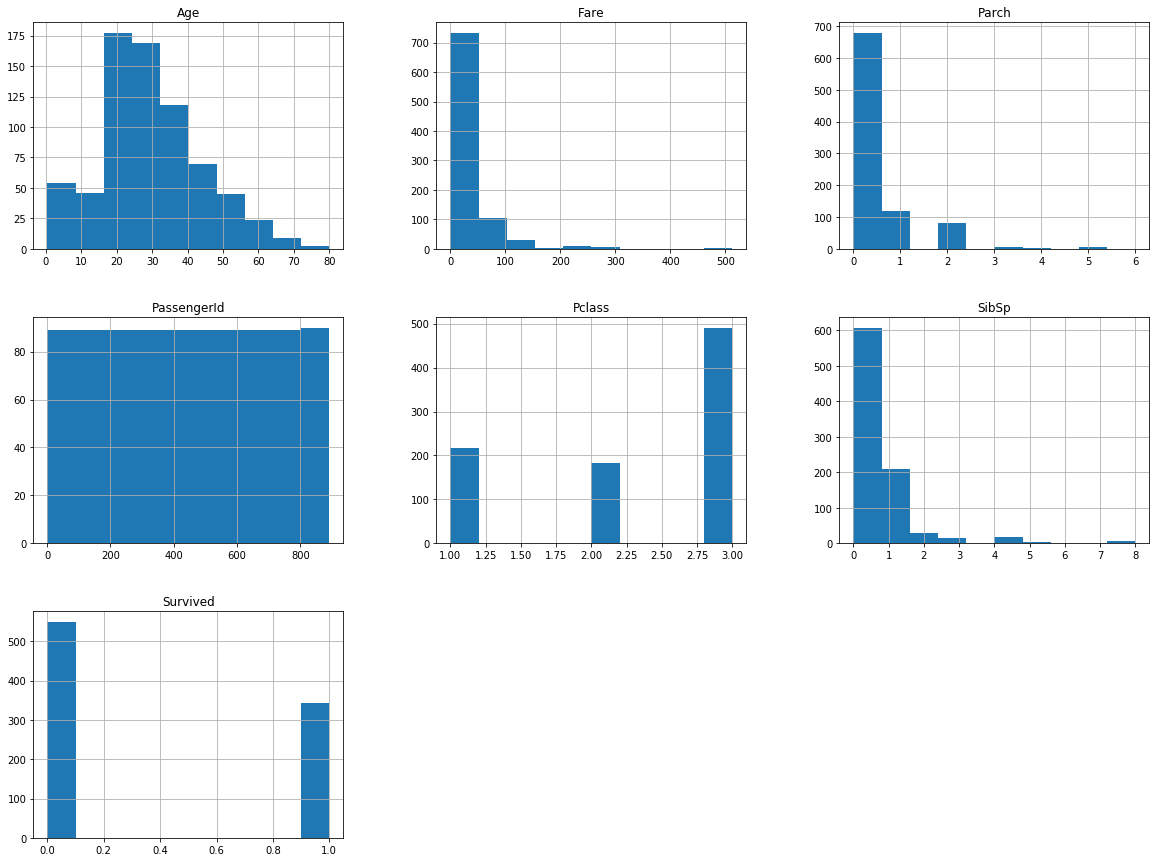

In [7]:
%matplotlib inline 

train_data.hist(bins=10, figsize=(20,15))
plt.show()

In [8]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [9]:
# Set label for graphs
train_survived = 'survived'
train_not_survived = 'not survived'

### Age

E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Age')

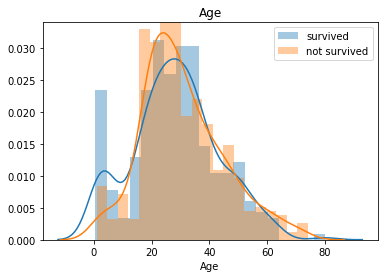

In [10]:
ax = sns.distplot(train_data[train_data['Survived']==1].Age.dropna(), bins=20, label = train_survived)
ax = sns.distplot(train_data[train_data['Survived']==0].Age.dropna(), bins=20, label = train_not_survived)
ax.legend()
ax.set_title('Age')

### Parch

In [11]:
train_data.groupby("Parch").agg([ "count", "mean"])["Survived"]

,count,mean
Parch,,
0,678,0.343658
1,118,0.550847
2,80,0.500000
3,5,0.600000
4,4,0.000000
5,5,0.200000
6,1,0.000000


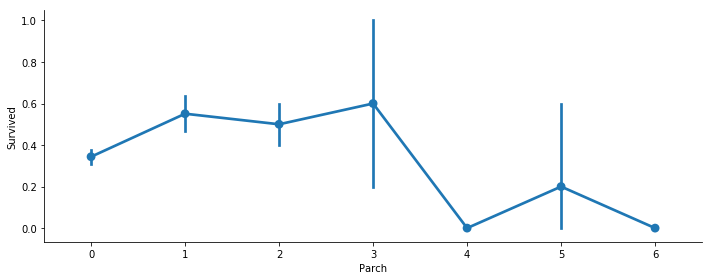

In [12]:
axes = sns.factorplot('Parch','Survived', data=train_data, aspect = 2.5, )

### SibSp

In [13]:
train_data.groupby("SibSp").agg([ "count", "mean"])["Survived"]

,count,mean
SibSp,,
0,608,0.345395
1,209,0.535885
2,28,0.464286
3,16,0.250000
4,18,0.166667
5,5,0.000000
8,7,0.000000


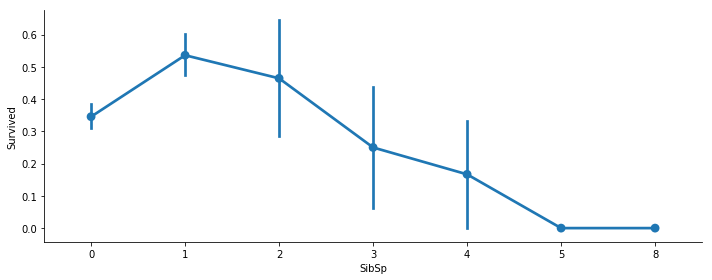

In [14]:
axes = sns.factorplot('SibSp','Survived', data=train_data, aspect = 2.5, )

### Fare

E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


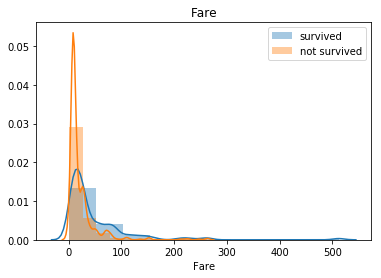

In [15]:
ax = sns.distplot(train_data[train_data['Survived']==1].Fare.dropna(), bins=10, label = train_survived)
ax = sns.distplot(train_data[train_data['Survived']==0].Fare.dropna(), bins=10, label = train_not_survived)
ax.legend()
_ = ax.set_title('Fare')

## Categorical Columns

### Pclass

In [16]:
train_data.groupby("Pclass").agg([ "count", "mean"])["Survived"]

,count,mean
Pclass,,
1,216,0.629630
2,184,0.472826
3,491,0.242363


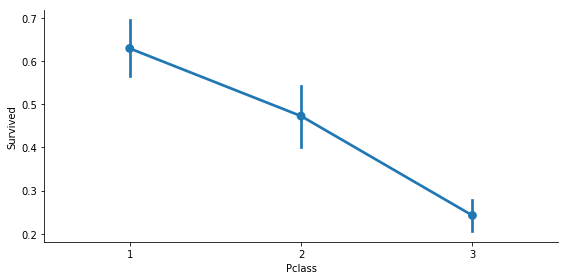

In [17]:
axes = sns.factorplot('Pclass','Survived', data=train_data, aspect = 2, )

### Sex

In [18]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [19]:
# Dislay how many male/female in total and the percentage of survival
train_data.groupby("Sex").agg([ "count", "mean"])["Survived"]

,count,mean
Sex,,
female,314,0.742038
male,577,0.188908


### Embarked

In [20]:
# Port of Embarkation
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [21]:
# Do the same for Embarked data
train_data.groupby("Embarked").agg(["count", "mean"])["Survived"]

,count,mean
Embarked,,
C,168,0.553571
Q,77,0.389610
S,644,0.336957


## Consider Attributes Together

### Consider Sex and Age attributes together

E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
E:\Visual Studio\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


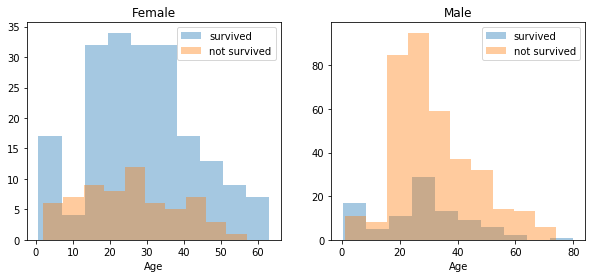

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
train_females = train_data[train_data['Sex']=='female']
train_males = train_data[train_data['Sex']=='male']
ax = sns.distplot(train_females[train_females['Survived']==1].Age.dropna(), bins=10, label = train_survived, ax = axes[0], kde = False)
ax = sns.distplot(train_females[train_females['Survived']==0].Age.dropna(), bins=10, label = train_not_survived, ax = axes[0], kde = False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(train_males[train_males['Survived']==1].Age.dropna(), bins=10, label = train_survived, ax = axes[1], kde = False)
ax = sns.distplot(train_males[train_males['Survived']==0].Age.dropna(), bins=10, label = train_not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

### Consider the Pclass, Sex, Embarked attributes at the same time

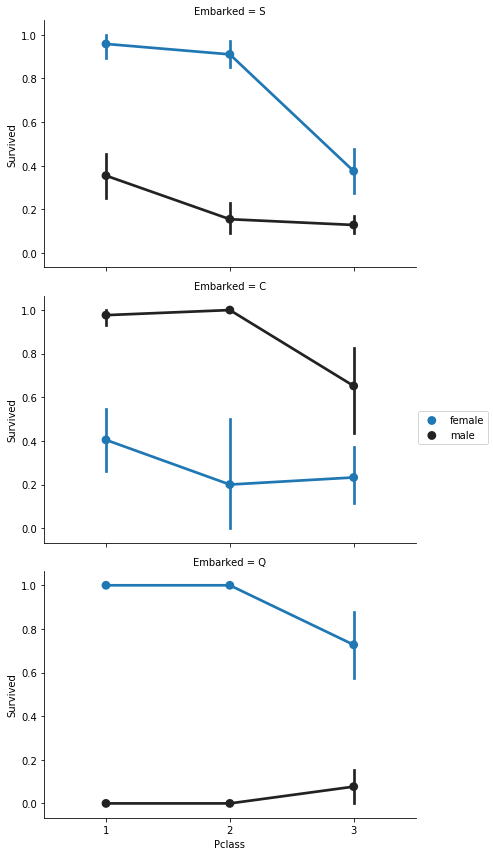

In [23]:
pclass_plot = sns.FacetGrid(train_data, row='Embarked', size=4, aspect=1.5)
pclass_plot.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
pclass_plot.add_legend()

### Age with Pclass

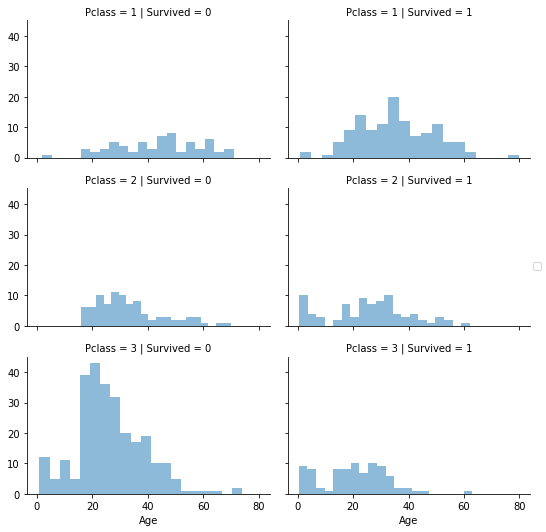

In [24]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.5, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

From above we could see:

- Female had a higher chance to survive than male
- People with less relatives had a higher chance to survive than people with mant relatives on board
- People younger than 40 had a higher chance to survive than those above
- Male kids had a higher chance to survive than female kids

# Data Transformation Preparations (Pipelines)

In [25]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
# Fill in the missing values with most frequent situation
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


# Build the Models

## Develop Baseline Model

The baseline model is just the logistic regression base on our preprocessed data without any feature engineering and contains cheating as in the lecture. This is intend to better improve my model. With this model as baseline, it would be more directly and easier to see whether certain feature change, drop, or merge actually improve the model or not.

In [26]:
base_data = train_data.copy()

In [27]:
# Convert Embarked to numerical values
ports = {"S": -1, "Q": 0, "C": 1}
base_data['Embarked'] = base_data['Embarked'].map(ports)

# Convert Sex to numerical values
sex_map = {"male": -1, "female": 1}
base_data['Sex'] = base_data['Sex'].map(sex_map)

# In Baseline model, we treat everything as numerical
base_attribs = ["Age", "SibSp", "Parch", "Fare", "Sex", "Pclass", "Embarked"]

# build base pipeline
base_pipeline = Pipeline([
    ("num_selector", DataFrameSelector(base_attribs)),
    ("num_imputer", SimpleImputer(strategy = "median")),
    ])

In [28]:
X_base = base_pipeline.fit_transform(base_data)
y_base = base_data["Survived"]

In [29]:
baseline_clf = linear_model.LogisticRegression(solver='liblinear')
baseline_clf.fit(X_base, y_base)
y_base_predict = baseline_clf.predict(X_base)

baseline_cross_val = cross_val_score(baseline_clf, X_base, y_base, cv=5)
baseline_cross_val.mean()

0.7912726032143562

In [30]:
# accuracy score
SCORE_BASELINE = metrics.accuracy_score(y_base, y_base_predict)
SCORE_BASELINE

0.8002244668911336

In [31]:
# recall score
baseline_recall = metrics.recall_score(y_base, y_base_predict)
baseline_recall

0.695906432748538

In [32]:
# the confusion matrix will be 
baseline_confusion_mat = metrics.confusion_matrix(y_base, y_base_predict)
baseline_confusion_mat

array([[475,  74],
       [104, 238]], dtype=int64)

In [33]:
# area under the curve score
baseline_roc_score= metrics.roc_auc_score(y_base, y_base_predict)
baseline_roc_score

0.7805579522576934

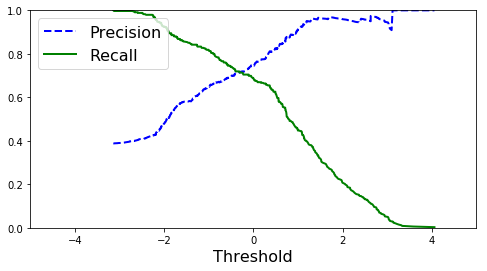

In [34]:
# plot the precision-recall curve
baseline_scores = cross_val_predict(baseline_clf, X_base, y_base, cv=5,
                             method="decision_function")

if baseline_scores.ndim == 2:
    baseline_scores = baseline_scores[:, 1]

baseline_precisions, baseline_recalls, baseline_thresholds = metrics.precision_recall_curve(y_base, baseline_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(baseline_precisions, \
                                   baseline_recalls, baseline_thresholds)
plt.xlim([-5, 5])
plt.show()

The baseline model has a accuracy of 0.80. According to the confusion matrix, it failed to classify the negative terms.According to the precision and recall graph, the equilibrium betwenn precision and recall will be around 0.7.

## Experiment 1

Stop cheating and encode the categorical features using one hot encoder

In [35]:
num_attribs_1 = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs_1 = ["Sex", "Pclass", "Embarked"]

In [36]:
# build numerical pipeline
num_pipeline_1 = Pipeline([
    ("num_selector", DataFrameSelector(num_attribs_1)),
    ("num_imputer", SimpleImputer(strategy = "median")),
    ])

# build categorical pipeline
cat_pipeline_1 = Pipeline([
    ("cat_selector", DataFrameSelector(cat_attribs_1)),
    ("cat_imputer",MostFrequentImputer()),
    ("cat_encoder",OneHotEncoder(sparse = False)),
    ])

# Combine the pipelines together
full_pipeline_1 = FeatureUnion(transformer_list=[
    ("num", num_pipeline_1),
    ("cat", cat_pipeline_1),
    ])

In [37]:
X_train_1 = full_pipeline_1.fit_transform(train_data)
y_train_1 = train_data["Survived"]

In [38]:
# to test the best C value
testlist = [0.001, 0.005,0.01,0.05, 0.1,0.5, 1,5,10,50,100,500,1000]
testlist

[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

In [39]:
for i in testlist:
    experiment_1_clf = linear_model.LogisticRegression(solver='liblinear',C=i)
    experiment_1_clf.fit(X_train_1, y_train_1)
    y_train_1_predict = experiment_1_clf.predict(X_train_1)

    experiment_1_cross_val = cross_val_score(experiment_1_clf, X_train_1, y_train_1, cv=5)
    print("C=", i, "CV score is", experiment_1_cross_val.mean(),"Accuracy is",\
          metrics.accuracy_score(y_train_1, y_train_1_predict))

C= 0.001 CV score is 0.6970274705146169 Accuracy is 0.7048260381593715
C= 0.005 CV score is 0.7318405964705844 Accuracy is 0.7384960718294051
C= 0.01 CV score is 0.7633208820382533 Accuracy is 0.7811447811447811
C= 0.05 CV score is 0.7980017639630228 Accuracy is 0.8092031425364759
C= 0.1 CV score is 0.7957545020244436 Accuracy is 0.8092031425364759
C= 0.5 CV score is 0.7968907225971325 Accuracy is 0.8058361391694725
C= 1 CV score is 0.7913041304183615 Accuracy is 0.8058361391694725
C= 5 CV score is 0.7901868119826072 Accuracy is 0.8058361391694725
C= 10 CV score is 0.7901868119826072 Accuracy is 0.8058361391694725
C= 50 CV score is 0.7901868119826072 Accuracy is 0.8047138047138047
C= 100 CV score is 0.7901868119826072 Accuracy is 0.8047138047138047
C= 500 CV score is 0.7901868119826072 Accuracy is 0.8047138047138047
C= 1000 CV score is 0.7901868119826072 Accuracy is 0.8047138047138047


In [40]:
experiment_1_clf = linear_model.LogisticRegression(solver='liblinear',C=0.05)
experiment_1_clf.fit(X_train_1, y_train_1)
y_train_1_predict = experiment_1_clf.predict(X_train_1)

experiment_1_cross_val = cross_val_score(experiment_1_clf, X_train_1, y_train_1, cv=5)
experiment_1_cross_val.mean()

0.7980017639630228

In [41]:
# accuracy score
SCORE_1 = metrics.accuracy_score(y_train_1, y_train_1_predict)
SCORE_1

0.8092031425364759

In [42]:
# the confusion matrix will be 
experiment_1_confusion_mat = metrics.confusion_matrix(y_train_1, y_train_1_predict)
experiment_1_confusion_mat

array([[488,  61],
       [109, 233]], dtype=int64)

In [43]:
experiment_1_roc_score= metrics.roc_auc_score(y_train_1, y_train_1_predict)
experiment_1_roc_score

0.7850877192982456

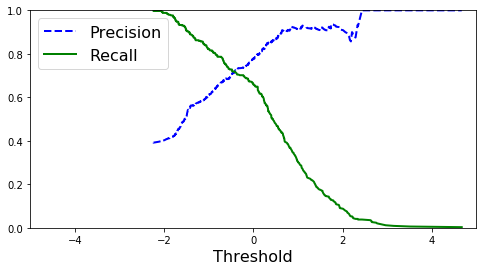

In [44]:
# plot the precision-recall curve
exp1_scores = cross_val_predict(experiment_1_clf, X_train_1, y_train_1, cv=5,
                             method="decision_function")

if exp1_scores.ndim == 2:
    exp1_scores = exp1_scores[:, 1]

exp1_precisions, exp1_recalls, exp1_thresholds = metrics.precision_recall_curve(y_train_1, exp1_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(exp1_precisions, exp1_recalls, exp1_thresholds)
plt.xlim([-5, 5])
plt.show()

In [45]:
# generate the missclassified list for not survive but classified as survived
MISCLASSIFIED_SURVIVE_1 = list()
for i in range(len(y_train_1)):
    if (y_train_1[i]==0) and (y_train_1_predict[i] == 1):
        MISCLASSIFIED_SURVIVE_1.append(i)

# generate the missclassified list for survived but classified as not survived
MISCLASSIFIED_NOT_SURVIVE_1 = list()
for i in range(len(y_train_1)):
    if (y_train_1[i]==1) and (y_train_1_predict[i] == 0):
        MISCLASSIFIED_NOT_SURVIVE_1.append(i)

In [46]:
train_data.loc[MISCLASSIFIED_SURVIVE_1].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,NaN,S
100,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S


In [47]:
train_data.loc[MISCLASSIFIED_NOT_SURVIVE_1].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C


The experiment 1 doesn't change significantly from our baseline model. Hence we will continue enhancing.

## Experiment 2

Since there are too many age missing in the dataset, it's better to use the <span style="color:blue">distribution of age</span> to fill in the missing values.In this experiment, we also add a scaler for the numerical attributes.

In [48]:
experiment_data = train_data.copy()

# to make sure the missing value genetated won't change every time you run the program
np.random.seed(42)

In [49]:
# Fill in the missing age data according to its population
age_dist = experiment_data["Age"].value_counts(normalize=True)
age_missing = experiment_data["Age"].isnull()
experiment_data.loc[age_missing,'Age'] = np.random.choice(age_dist.index, \
                                                          size=len(experiment_data[age_missing]),\
                                                          p=age_dist.values)

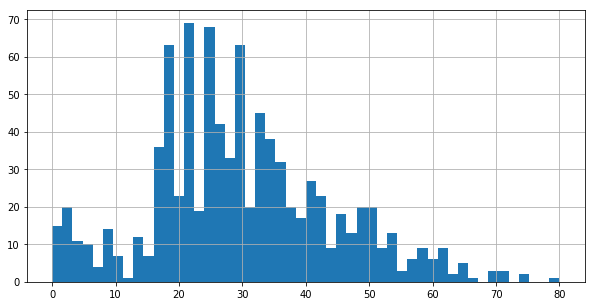

In [50]:
%matplotlib inline 

experiment_data['Age'] = experiment_data['Age'].astype(int)
experiment_data["Age"].hist(bins=50, figsize=(10,5))
plt.show()

In [51]:
# convert age into relatively balanced buckets
experiment_data.loc[ experiment_data['Age'] <= 16, 'Age'] = 0
experiment_data.loc[(experiment_data['Age'] > 16) & (experiment_data['Age'] <= 21), 'Age'] = 1
experiment_data.loc[(experiment_data['Age'] > 21) & (experiment_data['Age'] <= 25), 'Age'] = 2
experiment_data.loc[(experiment_data['Age'] > 25) & (experiment_data['Age'] <= 30), 'Age'] = 3
experiment_data.loc[(experiment_data['Age'] > 30) & (experiment_data['Age'] <= 36), 'Age'] = 4
experiment_data.loc[(experiment_data['Age'] > 36) & (experiment_data['Age'] <= 45), 'Age'] = 5
experiment_data.loc[experiment_data['Age'] > 45, 'Age'] = 6

# see how it's distributed 
experiment_data['Age'] = experiment_data['Age'].astype(int)
experiment_data['Age'].value_counts()

3    138
1    137
4    135
6    128
2    123
0    119
5    111
Name: Age, dtype: int64

Since we don't want all the people fall into one certain category, the results seem to be balanced.

In [52]:
num_attribs_2=["SibSp", "Parch","Fare"]
cat_attribs_2 = ["Sex", "Pclass", "Embarked","Age"]

# to keep the new attributes as originally encoded
age_attribs = [ "Age"]

num_pipeline_2 = Pipeline([
    ("num_selector", DataFrameSelector(num_attribs_2)),
    ("num_imputer", SimpleImputer(strategy = "median")),
    ('std_scaler', StandardScaler()),
    ])

cat_pipeline_2 = Pipeline([
    ("cat_selector", DataFrameSelector(cat_attribs_2)),
    ("cat_imputer",MostFrequentImputer()),
    ("cat_encoder",OneHotEncoder(sparse=False)),
    ])

age_pipeline = Pipeline([
    ("cat_selector", DataFrameSelector(age_attribs)),
    ("cat_imputer",MostFrequentImputer()),
    ("cat_encoder",OrdinalEncoder()),
    ])

full_pipeline_2 = FeatureUnion(transformer_list=[
    ("num", num_pipeline_2),
    ("cat", cat_pipeline_2),
    ("age", age_pipeline),
])

In [53]:
X_train_2 = full_pipeline_2.fit_transform(experiment_data)
y_train_2 = experiment_data["Survived"]

In [54]:
# Check for a best C value
for i in testlist:
    experiment_2_clf = linear_model.LogisticRegression(solver='liblinear',C=i)
    experiment_2_clf.fit(X_train_2, y_train_2)
    y_train_2_predict = experiment_2_clf.predict(X_train_2)

    experiment_2_cross_val = cross_val_score(experiment_2_clf, X_train_2, y_train_2, cv=5)
    print("C=", i, "CV score is", experiment_2_cross_val.mean(),"Accuracy is", metrics.accuracy_score(y_train_2, y_train_2_predict))

C= 0.001 CV score is 0.6577134726842843 Accuracy is 0.6677890011223344
C= 0.005 CV score is 0.7464098884064648 Accuracy is 0.7789001122334456
C= 0.01 CV score is 0.7823404037255296 Accuracy is 0.8047138047138047
C= 0.05 CV score is 0.7946435315858964 Accuracy is 0.8125701459034792
C= 0.1 CV score is 0.7912663970718355 Accuracy is 0.8080808080808081
C= 0.5 CV score is 0.7923899925774535 Accuracy is 0.8047138047138047
C= 1 CV score is 0.7923773675103829 Accuracy is 0.8013468013468014
C= 5 CV score is 0.7946181395970688 Accuracy is 0.8069584736251403
C= 10 CV score is 0.7946181395970688 Accuracy is 0.8080808080808081
C= 50 CV score is 0.7957480830998936 Accuracy is 0.8080808080808081
C= 100 CV score is 0.7957480830998936 Accuracy is 0.8080808080808081
C= 500 CV score is 0.7957480830998936 Accuracy is 0.8080808080808081
C= 1000 CV score is 0.7957480830998936 Accuracy is 0.8080808080808081


In [55]:
# Use the best C value to generate the result
experiment_2_clf = linear_model.LogisticRegression(solver='liblinear',C=0.05)
experiment_2_clf.fit(X_train_2, y_train_2)
y_train_2_predict = experiment_2_clf.predict(X_train_2)

experiment_2_cross_val = cross_val_score(experiment_2_clf, X_train_2, y_train_2, cv=5)
experiment_2_cross_val.mean()

0.7946435315858964

In [56]:
SCORE_2 = metrics.accuracy_score(y_train_2, y_train_2_predict)
SCORE_2

0.8125701459034792

In [57]:
# the confusion matrix will be 
experiment_2_confusion_mat = metrics.confusion_matrix(y_train_2, y_train_2_predict)
experiment_2_confusion_mat

array([[493,  56],
       [111, 231]], dtype=int64)

In [58]:
experiment_2_roc_score= metrics.roc_auc_score(y_train_2, y_train_2_predict)
experiment_2_roc_score

0.7867174767519893

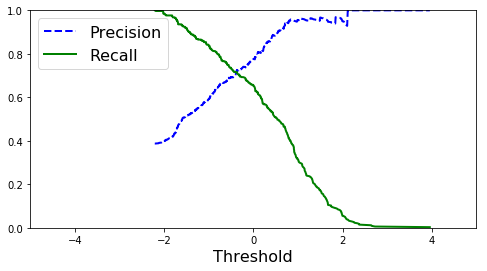

In [59]:
# plot the precision-recall curve
exp2_scores = cross_val_predict(experiment_2_clf, X_train_2, y_train_2, cv=5,
                             method="decision_function")

if exp2_scores.ndim == 2:
    exp2_scores = exp2_scores[:, 1]

exp2_precisions, exp2_recalls, exp2_thresholds = metrics.precision_recall_curve(y_train_2, exp2_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(exp2_precisions, exp2_recalls, exp2_thresholds)
plt.xlim([-5, 5])
plt.show()

In [60]:
# generate the missclassified list for not survive but classified as survived
MISCLASSIFIED_SURVIVE_2 = list()
for i in range(len(y_train_2)):
    if (y_train_2[i]==0) and (y_train_2_predict[i] == 1):
        MISCLASSIFIED_SURVIVE_2.append(i)

# generate the missclassified list for survived but classified as not survived
MISCLASSIFIED_NOT_SURVIVE_2 = list()
for i in range(len(y_train_2)):
    if (y_train_2[i]==1) and (y_train_2_predict[i] == 0):
        MISCLASSIFIED_NOT_SURVIVE_2.append(i)

In [61]:
train_data.loc[MISCLASSIFIED_SURVIVE_2].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
100,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S


In [62]:
train_data.loc[MISCLASSIFIED_NOT_SURVIVE_2].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C


The experiment 2 model has increased the accuracy to 0.81. According to the confusion matrix, it also failed to classify the negative terms. But the overall equilibrium is higher, around 0.73 this case.

## Extra Credit (Experiment 3)

In this part, we will try to do some feature engineering and change the way we treat our data.

In [63]:
challenge_data = train_data.copy()

**Step 1: Data cleaning**

First, we will try to fill the missing ages according to their titles (eg, Mr, Mrs...)

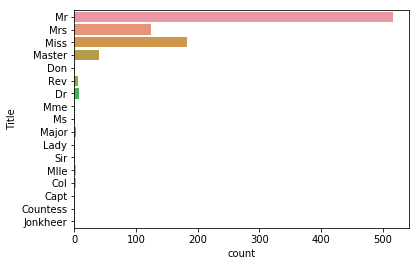

In [64]:
# Get the Title of people
challenge_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

#Plotting the various titles extracted from the names    
sns.countplot(y='Title',data=challenge_data)  

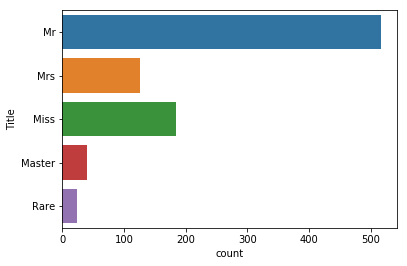

In [65]:
# Refine the categories
challenge_data['Title'] = challenge_data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

challenge_data['Title'] = challenge_data['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# Now plot the results 
sns.countplot(y='Title',data=challenge_data)  

In [66]:
# label titles with number
title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
challenge_data['Title'] = challenge_data['Title'].map(title_map)
challenge_data['Title'] = challenge_data['Title'].fillna(0)

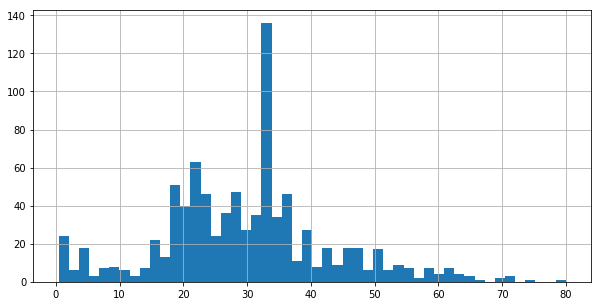

In [67]:
# Fill in the ages according to their titles
challenge_data['Age'] = challenge_data.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.mean()))    

%matplotlib inline 
challenge_data["Age"].hist(bins=50, figsize=(10,5))
plt.show()

In [68]:
# convert Fare to buckets
challenge_data['Fare'] = challenge_data.groupby(['Pclass'])['Fare'].transform(lambda x: x.fillna(x.mean()))  
challenge_data.loc[challenge_data['Fare'] <= 7.8, 'Fare'] = 1
challenge_data.loc[(challenge_data['Fare'] > 7.8) & (challenge_data['Fare'] <= 11), 'Fare'] = 2
challenge_data.loc[(challenge_data['Fare'] > 11) & (challenge_data['Fare'] <= 24), 'Fare']   = 3
challenge_data.loc[(challenge_data['Fare'] > 24) & (challenge_data['Fare'] <= 50), 'Fare']   = 4
challenge_data.loc[challenge_data['Fare'] > 50, 'Fare']   = 5
challenge_data['Fare'] = challenge_data['Fare'].astype(int)
challenge_data['Fare'].value_counts()

2    200
3    185
4    182
1    164
5    160
Name: Fare, dtype: int64

**Step 2: Add New Features**

Since from previous graphical analysis, we found

- People of different age had different survival rate, and the distributions are sexually different
- People with different amount of companions tend to have different survival rate
- The embarked place altogether with the class of the passenger somehow affect their survival rate

Hence, we can create some new features considering these aspects

In [69]:
# Convert Embarked to numerical values
ports = {"S": 0, "C": 2, "Q": 1}
challenge_data['Embarked'] = challenge_data['Embarked'].map(ports)

# Create some new features
challenge_data['IsMale'] = np.where(challenge_data["Sex"]=='male',1,0)
challenge_data['IsFemale'] = np.where(challenge_data['Sex']=='female',1,0)

challenge_data['Male_Age'] = challenge_data['IsMale']*challenge_data['Age']
challenge_data['Female_Age'] = challenge_data['IsFemale']*challenge_data['Age']
challenge_data['Male_Pclass'] = challenge_data['IsMale']*challenge_data['Pclass']
challenge_data['Female_Pclass'] = challenge_data['IsFemale']*challenge_data['Pclass']
challenge_data['Male_Embarked'] = challenge_data['IsMale']*challenge_data['Embarked']
challenge_data['Female_Embarked'] = challenge_data['IsFemale']*challenge_data['Embarked']
challenge_data['Embarked_Pclass'] = challenge_data['Pclass']*challenge_data['Embarked']
challenge_data['Male_Embarked_Pclass'] = challenge_data['IsMale']*challenge_data['Pclass']*challenge_data['Embarked']
challenge_data['Female_Embarked_Pclass'] = challenge_data['IsFemale']*challenge_data['Pclass']*challenge_data['Embarked']

challenge_data["Companion"]=challenge_data["SibSp"]+challenge_data["Parch"]
challenge_data['Pclass_SibSp'] = challenge_data['SibSp']*challenge_data['Pclass']
challenge_data['Pclass_Parch'] = challenge_data['Parch']*challenge_data['Pclass']
challenge_data["Fare_per_person"] = challenge_data["Fare"]/(challenge_data["Companion"]+1)
challenge_data["Age_with_class"] = challenge_data["Age"]*challenge_data["Pclass"]
challenge_data["Travel_alone"]= np.where(challenge_data["Companion"] > 0, 0,1)

# drop the one hot created by myself
challenge_data.drop('IsMale',axis=1,inplace=True)
challenge_data.drop('IsFemale',axis=1,inplace=True)

**Step 3: Test Importance of New Attributes**

In [70]:
exp_num_attribs = ["Age", "SibSp", "Parch", "Fare", "Male_Age", "Female_Age", \
                   "Age_with_class","Pclass_SibSp","Pclass_Parch","Companion"]
exp_cat_attribs = ["Pclass", "Embarked", "Title", "Male_Pclass", "Female_Pclass","Fare_per_person", "Male_Embarked",\
                   "Female_Embarked", "Embarked_Pclass","Male_Embarked_Pclass", "Female_Embarked_Pclass", "Travel_alone"]
exp_num_pipeline = Pipeline([
    ("num_selector", DataFrameSelector(exp_num_attribs)),
    ("num_imputer", SimpleImputer(strategy = "median")),
    ('std_scaler', StandardScaler()),
    ])

exp_cat_pipeline = Pipeline([
    ("cat_selector", DataFrameSelector(exp_cat_attribs)),
    ("cat_imputer",MostFrequentImputer()),
    ("cat_encoder",OrdinalEncoder()),
    ])

exp_pipeline = FeatureUnion(transformer_list=[
    ("exp_num", exp_num_pipeline),
    ("exp_cat", exp_cat_pipeline),
])

X_experiment = exp_pipeline.fit_transform(challenge_data)
y_experiment = challenge_data["Survived"]


In [71]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_experiment, y_experiment)
random_forest.score(X_experiment, y_experiment)

0.9551066217732884

In [72]:
exp_columns = ["Age", "SibSp", "Parch", "Fare", "Male_Age", "Female_Age",  "Age_with_class","Pclass_SibSp",\
               "Pclass_Parch","Companion","Pclass", "Embarked", "Title", "Male_Pclass", "Female_Pclass","Fare_per_person", "Male_Embarked",\
               "Female_Embarked", "Embarked_Pclass","Male_Embarked_Pclass", "Female_Embarked_Pclass", "Travel_alone"]
importances = pd.DataFrame({'feature':exp_columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
Male_Age,0.161
Age_with_class,0.128
Age,0.100
Female_Age,0.093
Title,0.080
Female_Pclass,0.073
Fare_per_person,0.059
Male_Pclass,0.049
Fare,0.046


**Step 4: Build the Model**

In [73]:
num_attribs_3=["Male_Age", "Female_Age",  "Age_with_class","Pclass_SibSp","SibSp","Parch"]
cat_attribs_3 = ["Title","Male_Pclass", "Fare_per_person","Female_Pclass","Female_Embarked", \
                 "Pclass", "Female_Embarked_Pclass","Male_Embarked_Pclass","Embarked_Pclass"]

num_pipeline_3 = Pipeline([
    ("num_selector", DataFrameSelector(num_attribs_3)),
    ("num_imputer", SimpleImputer(strategy = "median")),
    ('std_scaler', StandardScaler()),
    ])

cat_pipeline_3 = Pipeline([
    ("cat_selector", DataFrameSelector(cat_attribs_3)),
    ("cat_imputer",MostFrequentImputer()),
    ("cat_encoder",OneHotEncoder(sparse=False, categories="auto")),
    ])

full_pipeline_3 = FeatureUnion(transformer_list=[
    ("num", num_pipeline_3),
    ("cat", cat_pipeline_3),
])

In [74]:
X_train_3 = full_pipeline_3.fit_transform(challenge_data)
y_train_3 = challenge_data["Survived"]

In [75]:
# Check for a best C value
for i in testlist:
    experiment_3_clf = linear_model.LogisticRegression(solver='liblinear',C=i)
    experiment_3_clf.fit(X_train_3, y_train_3)
    y_train_3_predict = experiment_3_clf.predict(X_train_3)

    experiment_3_cross_val = cross_val_score(experiment_3_clf, X_train_3, y_train_3, cv=5)
    print("C=", i, "CV score is", experiment_3_cross_val.mean(),\
          "Accuracy is", metrics.accuracy_score(y_train_3, y_train_3_predict))

C= 0.001 CV score is 0.8024581998569396 Accuracy is 0.8069584736251403
C= 0.005 CV score is 0.8102794289072188 Accuracy is 0.819304152637486
C= 0.01 CV score is 0.8170527419269611 Accuracy is 0.8181818181818182
C= 0.05 CV score is 0.8182142126337911 Accuracy is 0.8395061728395061
C= 0.1 CV score is 0.8317039194804432 Accuracy is 0.8428731762065096
C= 0.5 CV score is 0.8238510922988155 Accuracy is 0.8484848484848485
C= 1 CV score is 0.8272218788156694 Accuracy is 0.8428731762065096
C= 5 CV score is 0.8182581521228377 Accuracy is 0.8529741863075196
C= 10 CV score is 0.8182581521228377 Accuracy is 0.8529741863075196
C= 50 CV score is 0.8238762715056138 Accuracy is 0.8484848484848485
C= 100 CV score is 0.8238762715056138 Accuracy is 0.8484848484848485
C= 500 CV score is 0.8227589530698596 Accuracy is 0.8496071829405163
C= 1000 CV score is 0.8227589530698596 Accuracy is 0.8496071829405163


In [76]:
# Use the C with highest accuracy value to generate the result
experiment_3_clf = linear_model.LogisticRegression(solver='liblinear',C=10)
experiment_3_clf.fit(X_train_3, y_train_3)
y_train_3_predict = experiment_3_clf.predict(X_train_3)

experiment_3_cross_val = cross_val_score(experiment_3_clf, X_train_3, y_train_3, cv=5)
experiment_3_cross_val.mean()

0.8182581521228377

In [77]:
SCORE_3 = metrics.accuracy_score(y_train_3, y_train_3_predict)
SCORE_3

0.8529741863075196

In [78]:
# the confusion matrix will be 
experiment_3_confusion_mat = metrics.confusion_matrix(y_train_3, y_train_3_predict)
experiment_3_confusion_mat

array([[514,  35],
       [ 96, 246]], dtype=int64)

In [79]:
experiment_3_roc_score= metrics.roc_auc_score(y_train_3, y_train_3_predict)
experiment_3_roc_score

0.8277729843735021

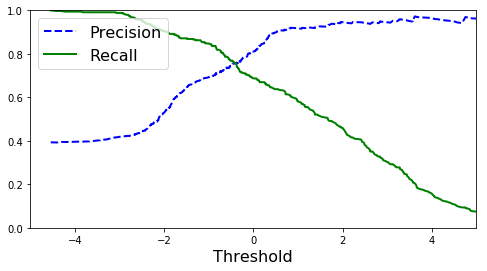

In [80]:
# plot the precision-recall curve
exp3_scores = cross_val_predict(experiment_3_clf, X_train_3, y_train_3, cv=5,
                             method="decision_function")

if exp3_scores.ndim == 2:
    exp3_scores = exp3_scores[:, 1]

exp3_precisions, exp3_recalls, exp3_thresholds = metrics.precision_recall_curve(y_train_3, exp3_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(exp3_precisions, exp3_recalls, exp3_thresholds)
plt.xlim([-5, 5])
plt.show()

In [81]:
# Use the best C with highest cross calidation mean to generate the result
experiment_4_clf = linear_model.LogisticRegression(solver='liblinear',C=0.1)
experiment_4_clf.fit(X_train_3, y_train_3)
y_train_4_predict = experiment_4_clf.predict(X_train_3)

experiment_4_cross_val = cross_val_score(experiment_4_clf, X_train_3, y_train_3, cv=5)
experiment_4_cross_val.mean()

0.8317039194804432

In [82]:
SCORE_4 = metrics.accuracy_score(y_train_3, y_train_4_predict)
SCORE_4

0.8428731762065096

In [83]:
experiment_4_roc_score= metrics.roc_auc_score(y_train_3, y_train_4_predict)
experiment_4_roc_score

0.8195762630620267

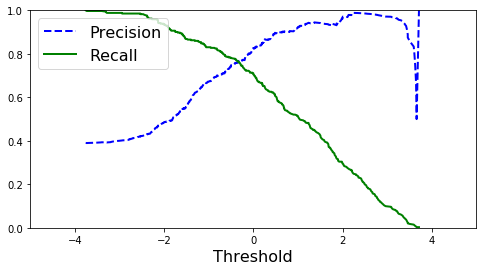

In [84]:
# plot the precision-recall curve
exp4_scores = cross_val_predict(experiment_4_clf, X_train_3, y_train_3, cv=5,
                             method="decision_function")

if exp4_scores.ndim == 2:
    exp4_scores = exp4_scores[:, 1]

exp4_precisions, exp4_recalls, exp4_thresholds = metrics.precision_recall_curve(y_train_3, exp4_scores)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(exp4_precisions, exp4_recalls, exp4_thresholds)
plt.xlim([-5, 5])
plt.show()

With feature engineering and new method for fillin the missing data, we reached an accuracy of 0.85 and it is substantially better than previous models and baseline model.

# <span style="color:red">**For Test Purpose**</span>

The rest part is used for test the model using the test set

In [85]:
"""
Load the test set

"""

test_data = 


SyntaxError: invalid syntax (<ipython-input-85-9c9d4c9bc3b4>, line 6)

## Baseline Model

In [ ]:
base_test = test_data.copy()

In [ ]:
# Convert Embarked to numerical values
ports2 = {"S": -1, "Q": 0, "C": 1}
base_test['Embarked'] = base_test['Embarked'].map(ports2)

# Convert Sex to numerical values
sex_map2 = {"male": -1, "female": 1}
base_test['Sex'] = base_test['Sex'].map(sex_map2)

In [ ]:
X_test = base_pipeline.fit_transform(base_test)
y_test = base_test["Survived"]
y_test_predict = baseline_clf.predict(X_test)

In [ ]:
baseline_test_cross_val = cross_val_score(baseline_clf, X_test, y_test, cv=5)
baseline_test_cross_val.mean()

In [ ]:
SCORE_BASELINE_test = metrics.accuracy_score(y_test, y_test_predict)
SCORE_BASELINE_test

In [ ]:
baseline_test_confusion_mat = metrics.confusion_matrix(y_test, y_test_predict)
baseline_test_confusion_mat

## Experiment 1

In [ ]:
X_test_1 = full_pipeline_1.fit_transform(test_data)
y_test_1 = test_data["Survived"]
y_test_1_predict = experiment_1_clf.predict(X_test_1)

test_exp_1_cross_val = cross_val_score(experiment_1_clf, X_test_1, y_test_1, cv=5)
test_exp_1_cross_val.mean()

In [ ]:
SCORE_1_test = metrics.accuracy_score(y_test_1, y_test_1_predict)
SCORE_1_test

In [ ]:
test_confusion_mat_1 = metrics.confusion_matrix(y_test_1, y_test_1_predict)
test_confusion_mat_1

## Experiment 2

In [ ]:
test_2_data = test_data.copy()

In [ ]:
# Fill in the missing age data according to its population
age_dist2 = test_2_data["Age"].value_counts(normalize=True)
age_missing2 = test_2_data["Age"].isnull()
test_2_data.loc[age_missing2,'Age'] = np.random.choice(age_dist2.index, size=len(test_2_data[age_missing2]),p=age_dist2.values)

In [ ]:
# convert age into buckets
test_2_data.loc[ test_2_data['Age'] <= 16, 'Age'] = 0
test_2_data.loc[(test_2_data['Age'] > 16) & (test_2_data['Age'] <= 21), 'Age'] = 1
test_2_data.loc[(test_2_data['Age'] > 21) & (test_2_data['Age'] <= 25), 'Age'] = 2
test_2_data.loc[(test_2_data['Age'] > 25) & (test_2_data['Age'] <= 30), 'Age'] = 3
test_2_data.loc[(test_2_data['Age'] > 30) & (test_2_data['Age'] <= 36), 'Age'] = 4
test_2_data.loc[(test_2_data['Age'] > 36) & (test_2_data['Age'] <= 45), 'Age'] = 5
test_2_data.loc[test_2_data['Age'] > 45, 'Age'] = 6

test_2_data['Age'] = test_2_data['Age'].astype(int)

In [ ]:
X_test_2 = full_pipeline_2.fit_transform(test_2_data)
y_test_2 = test_2_data["Survived"]
y_test_2_predict = experiment_2_clf.predict(X_test_2)

test_exp_2_cross_val = cross_val_score(experiment_2_clf, X_test_2, y_test_2, cv=5)
test_exp_2_cross_val.mean()

In [ ]:
SCORE_2_test = metrics.accuracy_score(y_test_2, y_test_2_predict)
SCORE_2_test

In [ ]:
test_2_confusion_mat = metrics.confusion_matrix(y_test_2, y_test_2_predict)
test_2_confusion_mat

## Extra Credit Model

In [ ]:
test_3_data = train_data.copy()

# Fill in the ages according to their titles
test_3_data['Title'] = test_3_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_3_data['Title'] = test_3_data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_3_data['Title'] = test_3_data['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# label titles with number
title_map2 = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
test_3_data['Title'] = test_3_data['Title'].map(title_map2)
test_3_data['Title'] = test_3_data['Title'].fillna(0)

test_3_data['Age'] = test_3_data.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.mean())) 

In [ ]:
# convert Fare to buckets
test_3_data['Fare'] = test_3_data.groupby(['Pclass'])['Fare'].transform(lambda x: x.fillna(x.mean()))  

test_3_data.loc[test_3_data['Fare'] <= 7.8, 'Fare'] = 1
test_3_data.loc[(test_3_data['Fare'] > 7.8) & (test_3_data['Fare'] <= 11), 'Fare'] = 2
test_3_data.loc[(test_3_data['Fare'] > 11) & (test_3_data['Fare'] <= 24), 'Fare']   = 3
test_3_data.loc[(test_3_data['Fare'] > 24) & (test_3_data['Fare'] <= 50), 'Fare']   = 4
test_3_data.loc[test_3_data['Fare'] > 50, 'Fare']   = 5
test_3_data['Fare'] = test_3_data['Fare'].astype(int)

In [ ]:
# Convert Embarked to numerical values
ports = {"S": 0, "C": 2, "Q": 1}
test_3_data['Embarked'] = test_3_data['Embarked'].map(ports)

# Create some new features
test_3_data['IsMale'] = np.where(test_3_data["Sex"]=='male',1,0)
test_3_data['IsFemale'] = np.where(test_3_data['Sex']=='female',1,0)

test_3_data['Male_Age'] = test_3_data['IsMale']*test_3_data['Age']
test_3_data['Female_Age'] = test_3_data['IsFemale']*test_3_data['Age']
test_3_data['Male_Pclass'] = test_3_data['IsMale']*test_3_data['Pclass']
test_3_data['Female_Pclass'] = test_3_data['IsFemale']*test_3_data['Pclass']
test_3_data['Female_Embarked'] = test_3_data['IsFemale']*test_3_data['Embarked']
test_3_data['Embarked_Pclass'] = test_3_data['Pclass']*test_3_data['Embarked']
test_3_data['Male_Embarked_Pclass'] = test_3_data['IsMale']*test_3_data['Pclass']*test_3_data['Embarked']
test_3_data['Female_Embarked_Pclass'] = test_3_data['IsFemale']*test_3_data['Pclass']*test_3_data['Embarked']

test_3_data["Companion"]=test_3_data["SibSp"]+test_3_data["Parch"]
test_3_data['Pclass_SibSp'] = test_3_data['SibSp']*test_3_data['Pclass']
test_3_data["Fare_per_person"] = test_3_data["Fare"]/(test_3_data["Companion"]+1)
test_3_data["Age_with_class"] = test_3_data["Age"]*test_3_data["Pclass"]

# drop the one hot created by myself
test_3_data.drop('IsMale',axis=1,inplace=True)
test_3_data.drop('IsFemale',axis=1,inplace=True)
test_3_data.drop('Companion',axis=1,inplace=True)

In [ ]:
X_test_3 = full_pipeline_3.fit_transform(test_3_data)
y_test_3 = challenge_data["Survived"]
y_test_3_predict = experiment_3_clf.predict(X_test_3)
y_test_4_predict = experiment_4_clf.predict(X_test_3)

### Highest accuracy model

In [ ]:
test_exp_3_cross_val = cross_val_score(experiment_3_clf, X_test_3, y_test_3, cv=5)
test_exp_3_cross_val.mean()

In [ ]:
SCORE_3_test = metrics.accuracy_score(y_test_3, y_test_3_predict)
SCORE_3_test

In [ ]:
test_3_confusion_mat = metrics.confusion_matrix(y_test_3, y_test_3_predict)
test_3_confusion_mat

### Highest cross validation model

In [ ]:
test_exp_4_cross_val = cross_val_score(experiment_4_clf, X_test_3, y_test_3, cv=5)
test_exp_4_cross_val.mean()

In [ ]:
SCORE_4_test = metrics.accuracy_score(y_test_3, y_test_4_predict)
SCORE_4_test

In [ ]:
test_4_confusion_mat = metrics.confusion_matrix(y_test_3, y_test_4_predict)
test_4_confusion_mat

End